# Introduction to Boosting
The term Boosting refers to a family of algorithms which converts weak learner to strong learners.

There are many boosting algorithms:
```
sklearn.ensemble.GradientBoostingRegressor
xgboost.XGBRegressor # fast and best
lightgbm.LGBMRegressor # extreme fast, little acc than xgb
catboost.CatBoostRegressor # good for categorical feats
```

# Imports

In [2]:
import sys
ENV_BHISHAN = None

try:
    import bhishan
    print('Environment: Personal environment')
    ENV_BHISHAN = True
    %load_ext autoreload
    %autoreload 2
except:
    print('Module "bhishan" not found.')

Module "bhishan" not found.


In [3]:
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    #!pip install hpsklearn
    !pip install shap eli5
    !pip install catboost
    !pip install ipywidgets
    !jupyter nbextension enable --py widgetsnbextension

    # set OMP_NUM_THREADS=1 for hpsklearn package
    #!export OMP_NUM_THREADS=1
    print('Environment: Google Colab')

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
Environment: Google Colab


In [0]:
import numpy as np
import pandas as pd

SEED = 100

In [0]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 8,8
plt.rcParams.update({'font.size': 16})

plt.style.use('ggplot')
%matplotlib inline

In [0]:
import seaborn as sns
sns.set(color_codes=True)

In [7]:
# boosting
import xgboost as xgb
import lightgbm as lgb
import catboost

from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBClassifier, DMatrix
from lightgbm import LGBMClassifier, Dataset
from catboost import CatBoostClassifier, Pool, CatBoost

print([(x.__name__,x.__version__) for x in [xgb, lgb,catboost]])

[('xgboost', '0.90'), ('lightgbm', '2.2.3'), ('catboost', '0.19.1')]


In [0]:
# six and pickle
import six
import pickle
import joblib

In [0]:
# scale and split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [0]:
# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [0]:
# sklearn scalar metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [0]:
# roc auc and curves
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

In [0]:
# confusion matrix and classification report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [0]:
import time

In [0]:
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK, STATUS_FAIL
from hyperopt.pyll import scope
from hyperopt.pyll.stochastic import sample
import copy
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [16]:
# model intepretation modules
import eli5
import shap
# shap_values = shap.TreeExplainer(model_xgb).shap_values(Xtest)
# shap.summary_plot(shap_values, Xtest)
# shap.dependence_plot("column_name", shap_values, Xtest)

Using TensorFlow backend.


# Useful Scripts

In [0]:
def show_method_attributes(obj, ncols=7,start=None, inside=None):
    """ Show all the attributes of a given method.
    Example:
    ========
    show_method_attributes(list)
     """
    lst = [elem for elem in dir(obj) if elem[0]!='_' ]
    lst = [elem for elem in lst 
           if elem not in 'os np pd sys time psycopg2'.split() ]

    if isinstance(start,str):
        lst = [elem for elem in lst if elem.startswith(start)]
        
    if isinstance(start,tuple) or isinstance(start,list):
        lst = [elem for elem in lst for start_elem in start
               if elem.startswith(start_elem)]
        
    if isinstance(inside,str):
        lst = [elem for elem in lst if inside in elem]
        
    if isinstance(inside,tuple) or isinstance(inside,list):
        lst = [elem for elem in lst for inside_elem in inside
               if inside_elem in elem]

    return pd.DataFrame(np.array_split(lst,ncols)).T.fillna('')

In [0]:
df_eval = pd.DataFrame({'Model': [],
                        'Description':[],
                        'Accuracy':[],
                        'Precision':[],
                        'Recall':[],
                        'F1':[],
                        'AUC':[],
                    })

# Load the data

In [19]:
ifile = 'https://github.com/bhishanpdl/Project_Fraud_Detection/blob/master/data/raw/creditcard.csv.zip?raw=true'
df = pd.read_csv(ifile,compression='zip')
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [20]:

target = 'Class'
features = df.columns.drop(target)
df[target].value_counts(normalize=True)*100

0    99.827251
1     0.172749
Name: Class, dtype: float64

# Train test split with stratify

In [21]:
from sklearn.model_selection import train_test_split

Xtrain_orig, Xtest, ytrain_orig, ytest = train_test_split(
    df.drop(target,axis=1), 
    df[target],
    test_size=0.2, 
    random_state=SEED, 
    stratify=df[target])

df_Xtrain_orig = pd.DataFrame(Xtrain_orig, columns=df.columns.drop(target))
df_Xtest = pd.DataFrame(Xtest, columns=df.columns.drop(target))

print(df_Xtrain_orig.shape)
df_Xtrain_orig.head()

(227845, 30)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
211885,138616.0,-1.137612,2.345154,-1.767247,0.833982,0.973168,-0.073571,0.802433,0.733137,-1.154087,-0.520340,0.494117,0.799935,0.494576,-0.479666,-0.917177,-0.184117,1.189459,0.937244,0.960749,0.062820,0.114953,0.430613,-0.240819,0.124011,0.187187,-0.402251,0.196277,0.190732,39.46
12542,21953.0,-1.028649,1.141569,2.492561,-0.242233,0.452842,-0.384273,1.256026,-0.816401,1.964560,-0.014216,0.432153,-2.140921,2.274477,0.114128,-1.652894,-0.617302,0.243791,-0.426168,-0.493177,0.350032,-0.380356,-0.037432,-0.503934,0.407129,0.604252,0.233015,-0.433132,-0.491892,7.19
270932,164333.0,-1.121864,-0.195099,1.282634,-3.172847,-0.761969,-0.287013,-0.586367,0.496182,-2.352349,0.350551,-1.319688,-0.942001,1.082210,-0.425735,0.036748,0.380392,-0.033353,0.204609,-0.801465,-0.113632,-0.328953,-0.856937,-0.056198,0.401905,0.406813,-0.440140,0.152356,0.030128,40.00
30330,35874.0,1.094238,-0.760568,-0.392822,-0.611720,-0.722850,-0.851978,-0.185505,-0.095131,-1.122304,0.367009,1.378493,-0.724216,-1.105406,-0.480170,0.220826,1.745743,0.740817,-0.728827,1.016740,0.354148,-0.227392,-1.254285,0.022116,-0.141531,0.114515,-0.652427,-0.037897,0.051254,165.85
272477,165107.0,2.278095,-1.298924,-1.884035,-1.530435,-0.649500,-0.996024,-0.466776,-0.438025,-1.612665,1.631133,-1.126000,-0.938760,0.300621,-0.119667,-0.585453,-1.106244,0.690235,-0.124401,-0.075649,-0.341708,0.123892,0.815909,-0.072537,0.784217,0.403428,0.193747,-0.043185,-0.058719,60.00


# Train Validation with stratify

In [22]:
Xtrain, Xvalid, ytrain, yvalid = train_test_split(
    Xtrain_orig, 
    ytrain_orig,
    test_size=0.2, 
    random_state=SEED, 
    stratify=ytrain_orig)

df_Xtrain = pd.DataFrame(Xtrain, columns=df.columns.drop(target))
df_Xvalid = pd.DataFrame(Xvalid, columns=df.columns.drop(target))

print(df_Xtrain.shape)

(182276, 30)


In [23]:
# random undersampling
n = df[target].value_counts().values[-1]
df_under = (df.groupby(target)
                .apply(lambda x: x.sample(n,random_state=SEED))
                .reset_index(drop=True))

Xtrain_orig_under, Xtest_under, ytrain_orig_under, ytest_under = train_test_split(
    df_under.drop(target,axis=1),
    df_under[target],
    test_size=0.2, 
    random_state=SEED, 
    stratify=df_under[target])

df_Xtrain_orig_under = pd.DataFrame(Xtrain_orig_under, columns=df_under.columns.drop(target))
df_Xtest_under = pd.DataFrame(Xtest_under, columns=df_under.columns.drop(target))


Xtrain_under, Xvalid_under, ytrain_under, yvalid_under = train_test_split(
    Xtrain_orig_under,
    ytrain_orig_under,
    test_size=0.2, 
    random_state=SEED, 
    stratify=ytrain_orig_under)



df_Xtrain_under = pd.DataFrame(Xtrain_under, columns=df_under.columns.drop(target))
df_Xvalid_under = pd.DataFrame(Xvalid_under, columns=df_under.columns.drop(target))


ytrain.value_counts(), ytest.value_counts(), yvalid.value_counts()

(0    181961
 1       315
 Name: Class, dtype: int64, 0    56864
 1       98
 Name: Class, dtype: int64, 0    45490
 1       79
 Name: Class, dtype: int64)

# Modelling catboost
https://catboost.ai/docs/concepts/python-reference_catboostregressor.html

```
class CatBoostRegressor(iterations=None,learning_rate=None,depth=None,
l2_leaf_reg=None,model_size_reg=None,rsm=None,loss_function='RMSE',
border_count=None,feature_border_type=None
per_float_feature_quantization=None,input_borders=None,
output_borders=None,fold_permutation_block=None,od_pval=None,
od_wait=None,od_type=None,nan_mode=None,counter_calc_method=None,
leaf_estimation_iterations=None,leaf_estimation_method=None,
thread_count=None,random_seed=None,use_best_model=None,
best_model_min_trees=None,verbose=None,silent=None,logging_level=None,
metric_period=None,ctr_leaf_count_limit=None,store_all_simple_ctr=None,
max_ctr_complexity=None,
has_time=None,allow_const_label=None,one_hot_max_size=None,
random_strength=None,name=None,ignored_features=None,
train_dir=None,custom_metric=None,eval_metric=None,
bagging_temperature=None,save_snapshot=None,
snapshot_file=None,snapshot_interval=None,
fold_len_multiplier=None,used_ram_limit=None,gpu_ram_part=None,
pinned_memory_size=None,allow_writing_files=None,
final_ctr_computation_mode=None,approx_on_full_history=None,
boosting_type=None,simple_ctr=None,combinations_ctr=None,
per_feature_ctr=None,ctr_target_border_count=None,task_type=None,
device_config=None,devices=None,bootstrap_type=None,subsample=None,
sampling_unit=None,dev_score_calc_obj_block_size=None,
max_depth=None,n_estimators=None,num_boost_round=None,
num_trees=None,colsample_bylevel=None,random_state=None,
reg_lambda=None,objective=None,eta=None,max_bin=None,
gpu_cat_features_storage=None,data_partition=None,
metadata=None,early_stopping_rounds=None,cat_features=None,
grow_policy=None,min_data_in_leaf=None,min_child_samples=None,
max_leaves=None,num_leaves=None,score_function=None,
leaf_estimation_backtracking=None,ctr_history_unit=None,
monotone_constraints=None)
```

In [24]:
import catboost
show_method_attributes(catboost)

,0,1,2,3,4,5,6
0,CatBoost,CatBoostRegressor,EFstrType,MetricVisualizer,core,sum_models,version
1,CatBoostClassifier,CatboostError,FeaturesData,Pool,cv,train,widget
2,CatBoostError,,,,,,


In [25]:
from catboost import CatBoostClassifier, Pool

show_method_attributes(CatBoostClassifier)

,0,1,2,3,4,5,6
0,best_iteration_,drop_unused_features,get_best_score,get_object_importance,grid_search,predict,set_feature_names
1,best_score_,eval_metrics,get_borders,get_param,is_fitted,predict_proba,set_leaf_values
2,calc_feature_statistics,evals_result_,get_cat_feature_indices,get_params,iterate_leaf_indexes,random_seed_,set_params
3,calc_leaf_indexes,feature_importances_,get_evals_result,get_test_eval,learning_rate_,randomized_search,shrink
4,classes_,feature_names_,get_feature_importance,get_test_evals,load_model,save_borders,staged_predict
5,compare,fit,get_leaf_values,get_text_feature_indices,plot_predictions,save_model,staged_predict_proba
6,copy,get_all_params,get_leaf_weights,get_tree_leaf_counts,plot_tree,score,tree_count_
7,create_metric_calcer,get_best_iteration,get_metadata,,,,


In [27]:
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score,  precision_score, recall_score,f1_score
from sklearn.metrics import confusion_matrix

# time
time_start = time.time()

# current parameters
desc = 'default,random_state=100, numpy'

Xtr = Xtrain
Xtx = Xtest

ytr,ytx = ytrain, ytest

"""


"""

# fit the model
model_cat = CatBoostClassifier(verbose=100,random_state=100)

model_cat.fit(Xtr, ytr)

# fitted model
model = model_cat


# save the model
# joblib.dump(model_cat, 'model_cat.pkl')
# model_cat = joblib.load('model_cat.pkl')


# predictions
skf = StratifiedKFold(n_splits=2,shuffle=True,random_state=SEED)
ypreds_cv = cross_val_predict(model_cat, Xtx, ytx, cv=skf)
ypreds = ypreds_cv



# model evaluation
row_eval = ['catboost','default, seed=100', 
            accuracy_score(ytx, ypreds),
            precision_score(ytx, ypreds, average='micro'),
            recall_score(ytx, ypreds, average='micro'),
            f1_score(ytx, ypreds, average='micro'),
            roc_auc_score(ytx, ypreds),
       ]

df_eval.loc[len(df_eval)] = row_eval
df_eval = df_eval.drop_duplicates()
time_taken = time.time() - time_start
print('Time taken: {:.0f} min {:.0f} secs'.format(*divmod(time_taken,60)))
display(df_eval)

Learning rate set to 0.073099
0:	learn: 0.4520944	total: 90.2ms	remaining: 1m 30s
100:	learn: 0.0016060	total: 8.15s	remaining: 1m 12s
200:	learn: 0.0011228	total: 16.4s	remaining: 1m 5s
300:	learn: 0.0008612	total: 24.6s	remaining: 57s
400:	learn: 0.0006628	total: 32.6s	remaining: 48.8s
500:	learn: 0.0005038	total: 40.8s	remaining: 40.6s
600:	learn: 0.0003722	total: 48.9s	remaining: 32.5s
700:	learn: 0.0002731	total: 57s	remaining: 24.3s
800:	learn: 0.0001932	total: 1m 5s	remaining: 16.2s
900:	learn: 0.0001492	total: 1m 13s	remaining: 8.06s
999:	learn: 0.0001250	total: 1m 21s	remaining: 0us
Learning rate set to 0.043228
0:	learn: 0.5620845	total: 31.2ms	remaining: 31.2s
100:	learn: 0.0016339	total: 2.26s	remaining: 20.1s
200:	learn: 0.0008008	total: 4.49s	remaining: 17.8s
300:	learn: 0.0004417	total: 6.75s	remaining: 15.7s
400:	learn: 0.0002461	total: 9s	remaining: 13.4s
500:	learn: 0.0001709	total: 11.6s	remaining: 11.6s
600:	learn: 0.0001256	total: 13.9s	remaining: 9.21s
700:	learn:

,Model,Description,Accuracy,Precision,Recall,F1,AUC
0,catboost,"default, seed=100",0.999403,0.999403,0.999403,0.999403,0.85709


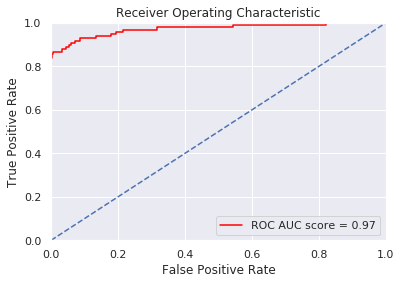

In [28]:
# calculate the FPR and TPR for all thresholds of the classification

from sklearn import metrics

yprobs = model_cat.predict_proba(df_Xtest)
ypreds = yprobs[:,1]

fpr, tpr, threshold = metrics.roc_curve(ytest, ypreds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'red', label = 'ROC AUC score = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [29]:
import eli5

# eli5.explain_weights_catboost(model_cat) # same thing
eli5.show_weights(model_cat)

Weight,Feature
0.0770,V4
0.0733,V14
0.0709,V1
0.0606,Amount
0.0537,V8
0.0493,Time
0.0479,V9
0.0453,V12
0.0443,V26
0.0396,V24


# Catboost with validation set

In [30]:
df_Xtrain.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
35574,38177.0,1.430419,-0.718078,0.364706,-0.744257,-0.556090,0.698948,-0.949852,0.131008,-0.314353,0.512322,-0.202255,0.766648,1.495082,-1.037475,-1.935434,0.897715,0.069580,-0.902556,1.843867,0.158424,0.042013,0.429576,-0.301931,-0.933773,0.840490,-0.027776,0.044688,-0.007522,0.2
46862,42959.0,-2.425523,-1.790293,2.522139,0.581141,0.918453,0.594426,0.224541,0.373885,-0.168411,-0.720421,1.394710,1.136436,0.508455,-0.389067,-0.165166,-0.040520,-0.464966,-0.057803,-1.493635,0.984535,0.538438,0.877560,0.590595,-0.293545,0.524022,-0.328189,-0.205285,-0.109163,300.0


In [31]:
# time
time_start = time.time()

# current parameters
Xtr = Xtrain
Xtx = Xtest
Xvd = Xvalid

ytr,ytx,yvd = ytrain, ytest,yvalid


# fit the model
model = CatBoostClassifier(random_state=0,verbose=100)
model.fit(Xtr, ytr,
          eval_set=(Xvd, yvd))


# ypreds
skf=StratifiedKFold(n_splits=5,shuffle=True,random_state=SEED)
ypreds = cross_val_predict(model, Xtx, ytx, cv=skf)

# r-squared values
r = roc_auc_score(ytx, ypreds)

# time
time_taken = time.time() - time_start
print('Time taken: {:.0f} min {:.0f} secs'.format(*divmod(time_taken,60)))

print('ROC AUC Score ', r)

Learning rate set to 0.134781
0:	learn: 0.3027203	test: 0.3029591	best: 0.3029591 (0)	total: 90ms	remaining: 1m 29s
100:	learn: 0.0011549	test: 0.0026406	best: 0.0026244 (85)	total: 8.42s	remaining: 1m 14s
200:	learn: 0.0007232	test: 0.0026344	best: 0.0026101 (153)	total: 16.7s	remaining: 1m 6s
300:	learn: 0.0004305	test: 0.0027123	best: 0.0026101 (153)	total: 25.1s	remaining: 58.2s
400:	learn: 0.0002653	test: 0.0027696	best: 0.0026101 (153)	total: 33.4s	remaining: 49.9s
500:	learn: 0.0001623	test: 0.0028454	best: 0.0026101 (153)	total: 41.7s	remaining: 41.6s
600:	learn: 0.0001167	test: 0.0028703	best: 0.0026101 (153)	total: 50s	remaining: 33.2s
700:	learn: 0.0000867	test: 0.0029258	best: 0.0026101 (153)	total: 58.4s	remaining: 24.9s
800:	learn: 0.0000702	test: 0.0029784	best: 0.0026101 (153)	total: 1m 6s	remaining: 16.6s
900:	learn: 0.0000601	test: 0.0030353	best: 0.0026101 (153)	total: 1m 14s	remaining: 8.22s
999:	learn: 0.0000533	test: 0.0030564	best: 0.0026101 (153)	total: 1m 22s	r

# Feature Statistics

[catboost tutorials model analysis feature statistics tutorial](https://github.com/catboost/tutorials/blob/master/model_analysis/feature_statistics_tutorial.ipynb)

In [32]:
# float feature
feature_name = 'Amount'
dict_stats = model.calc_feature_statistics(df_Xtrain, ytrain, feature_name, plot=True)

# Feature Importance

In [33]:
# feature importance
df_imp = pd.DataFrame({'Feature': features,
                       'Importance': model.feature_importances_
                       }) 

df_imp.sort_values('Importance',ascending=False).style.background_gradient()

,Feature,Importance
4,V4,10.0278
1,V1,7.65788
14,V14,6.21339
26,V26,6.16848
29,Amount,5.21334
16,V16,5.061
2,V2,4.97336
8,V8,4.86713
7,V7,3.80879
0,Time,3.64571


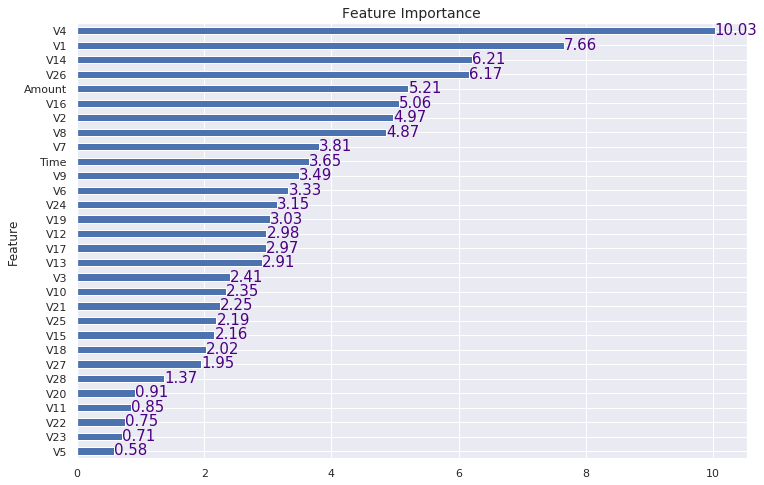

In [34]:
def plot_feature_imp_catboost(model_catboost,features):
    """Plot the feature importance horizontal bar plot.
    
    """

    df_imp = pd.DataFrame({'Feature': model.feature_names_,
                        'Importance': model.feature_importances_
                        }) 

    df_imp = df_imp.sort_values('Importance').set_index('Feature')
    ax = df_imp.plot.barh(figsize=(12,8))

    plt.grid(True)
    plt.title('Feature Importance',fontsize=14)
    ax.get_legend().remove()

    for p in ax.patches:
        x = p.get_width()
        y = p.get_y()
        text = '{:.2f}'.format(p.get_width())
        ax.text(x, y,text,fontsize=15,color='indigo')

    plt.show()

plot_feature_imp_catboost(model, features)

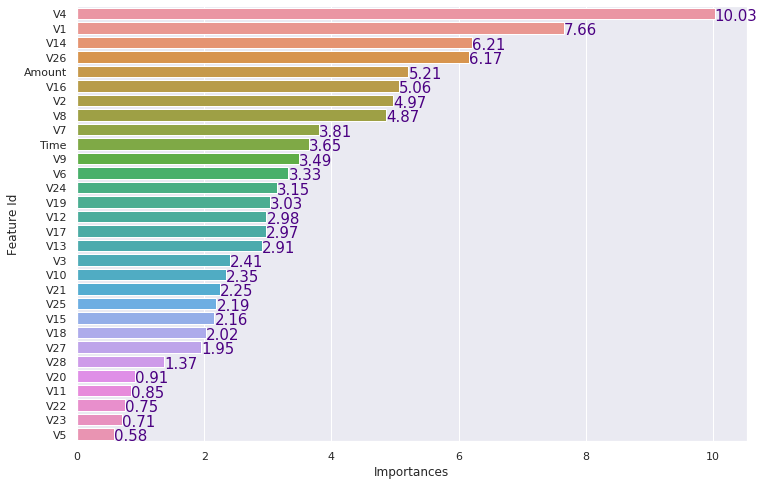

In [35]:
df_fimp = model.get_feature_importance(prettified=True)

plt.figure(figsize=(12,8))
ax = sns.barplot(x="Importances", y="Feature Id", data=df_fimp);

for p in ax.patches:
    x = p.get_width()
    y = p.get_y()
    text = '{:.2f}'.format(p.get_width())
    ax.text(x, y,text,fontsize=15,color='indigo',va='top',ha='left')

# catboost using Pool

In [0]:
from catboost import CatBoost, Pool

In [0]:
# help(CatBoost)

In [0]:
cat_features = [] # take it empty for the moment
dtrain = Pool(Xtrain, ytrain, cat_features=cat_features)
dvalid = Pool(Xvalid, yvalid, cat_features=cat_features)
dtest = Pool(Xtest, ytest, cat_features=cat_features)

In [39]:
params = {'iterations': 100, 'verbose': False, 
          'random_seed': 0,
          'eval_metric':'AUC',
          'loss_function':'Logloss',
          'cat_features': [],
          'ignored_features': [],
          'early_stopping_rounds': 200,
          'verbose': 200,
          }

bst_cat = CatBoost(params=params)

bst_cat.fit(dtrain,           
            eval_set=(df_Xvalid, yvalid), 
          use_best_model=True,
          plot=True);

print(bst_cat.eval_metrics(dtest, ['AUC'])['AUC'][-1])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.3611
0:	test: 0.9164238	best: 0.9164238 (0)	total: 94ms	remaining: 9.31s
99:	test: 0.9808154	best: 0.9840566 (35)	total: 8.6s	remaining: 0us

bestTest = 0.9840565878
bestIteration = 35

Shrink model to first 36 iterations.
0.9782066843338348


# Cross Validation
- [Catboost CV](https://catboost.ai/docs/concepts/python-usages-examples.html)
- [Catboost Jupyter Notebook visulization](https://catboost.ai/docs/features/visualization_jupyter-notebook.html)

```python
cv(pool=None, params=None, dtrain=None, iterations=None, 
num_boost_round=None, fold_count=None, nfold=None, inverted=False,
partition_random_seed=0, seed=None, shuffle=True, logging_level=None,
stratified=None, as_pandas=True, metric_period=None, verbose=None,
verbose_eval=None, plot=False, early_stopping_rounds=None,
save_snapshot=None, snapshot_file=None,
snapshot_interval=None, folds=None, type='Classical')
```

In [40]:
params = {'iterations': 100, 'verbose': False,
          'random_seed': 0,
          'loss_function':'Logloss',
          'eval_metric':'AUC',
          }

df_scores = catboost.cv(dtrain,
            params,
            fold_count=2,
            verbose=100,
            shuffle=True,
            stratified=True,
            plot="True") # plot does not work in google colab

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.9182109	best: 0.9182109 (0)	total: 262ms	remaining: 25.9s
99:	test: 0.9772304	best: 0.9784382 (54)	total: 15.1s	remaining: 0us


In [41]:
print(df_scores.columns)
df_scores.head()

Index(['iterations', 'test-AUC-mean', 'test-AUC-std', 'test-Logloss-mean',
       'test-Logloss-std', 'train-Logloss-mean', 'train-Logloss-std'],
      dtype='object')


,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.918211,0.015632,0.585840,0.001246,0.585823,0.001171
1,1,0.922383,0.027860,0.500689,0.002353,0.500659,0.002239
2,2,0.933871,0.022411,0.425035,0.003157,0.425024,0.003205
3,3,0.928061,0.020897,0.365778,0.003360,0.365737,0.003457
4,4,0.939572,0.017085,0.310018,0.004005,0.309959,0.003970


In [0]:
sns.lineplot(x='iterations',y='train-Logloss-mean',data=df_scores,ax=ax,color='r')
sns.lineplot(x='iterations',y='test-Logloss-mean',data=df_scores,ax=ax,color='b',alpha=0.2,linewidth=5,linestyle='--')

plt.show()

# Model Evaluation Using shap
- [official shap github repo](https://github.com/slundberg/shap)
- [catboost tutorials model analysis shap values tutorial](https://github.com/catboost/tutorials/blob/master/model_analysis/shap_values_tutorial.ipynb)

In [0]:
import shap

In [44]:
model = CatBoostClassifier(verbose=100,random_state=100)

model.fit(df_Xtrain, ytr)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df_Xtest)

Learning rate set to 0.073099
0:	learn: 0.4520944	total: 89.8ms	remaining: 1m 29s
100:	learn: 0.0016060	total: 8.19s	remaining: 1m 12s
200:	learn: 0.0011228	total: 16.4s	remaining: 1m 5s
300:	learn: 0.0008612	total: 24.6s	remaining: 57s
400:	learn: 0.0006628	total: 32.7s	remaining: 48.9s
500:	learn: 0.0005038	total: 40.9s	remaining: 40.8s
600:	learn: 0.0003722	total: 49.1s	remaining: 32.6s
700:	learn: 0.0002731	total: 57.3s	remaining: 24.5s
800:	learn: 0.0001932	total: 1m 5s	remaining: 16.3s
900:	learn: 0.0001492	total: 1m 13s	remaining: 8.11s
999:	learn: 0.0001250	total: 1m 21s	remaining: 0us


In [45]:
df_Xtrain.shape, df_Xtest.shape, shap_values.shape

((182276, 30), (56962, 30), (56962, 30))

In [46]:
df_Xtest.head(1)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
248750,154078.0,0.046622,1.529678,-0.453615,1.282569,1.110333,-0.882716,1.04642,-0.117121,-0.679897,-0.923709,0.371519,-0.000047,0.512255,-2.091762,0.786796,0.159652,1.706939,0.458922,0.037665,0.240559,-0.338472,-0.839547,0.066527,0.836447,0.07679,-0.775158,0.261012,0.058359,18.7


In [47]:
df_Xtest.head(1)['V15 V18 V3 V24 V1 V8 V4 V14 V2 V6 V9 V20'.split()].round(4)

,V15,V18,V3,V24,V1,V8,V4,V14,V2,V6,V9,V20
248750,0.7868,0.4589,-0.4536,0.8364,0.0466,-0.1171,1.2826,-2.0918,1.5297,-0.8827,-0.6799,0.2406


In [48]:
# load JS visualization code to notebook
shap.initjs()

# Look only first row of test data
# use matplotlib=True to avoid Javascript
shap.force_plot(explainer.expected_value,
                shap_values[0,:],
                df_Xtest.iloc[0,:],
                matplotlib=False,
                text_rotation=90)

In [0]:
# for this row, the predicted label is -9.33
# red features makes it higher
# blue features makes it smaller.

In [55]:
# visualize the test set predictions
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:100,:], df_Xtest.iloc[:100,:],matplotlib=False)

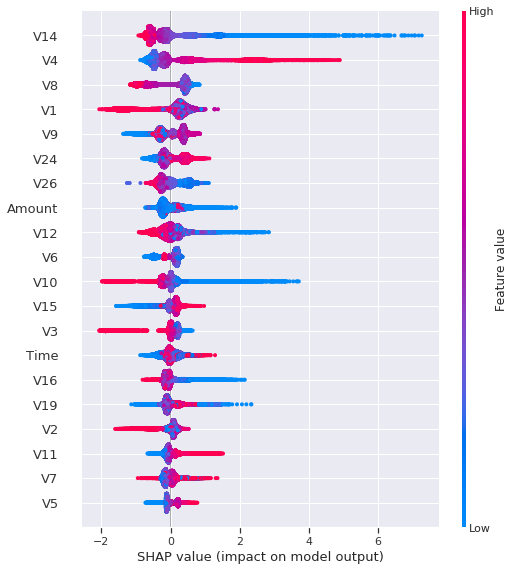

In [51]:
shap.summary_plot(shap_values, df_Xtest)

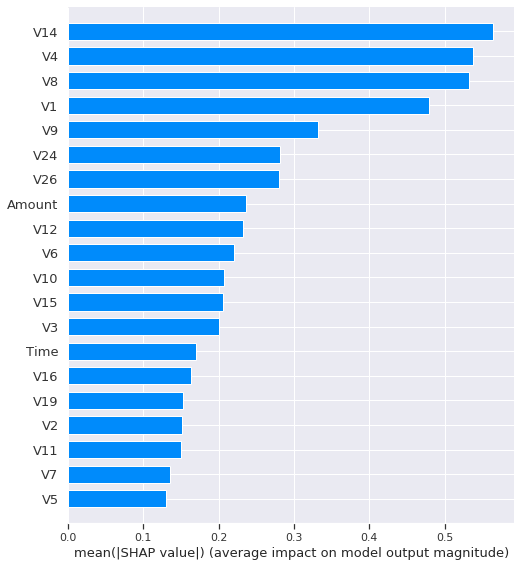

In [52]:
shap.summary_plot(shap_values, df_Xtest, plot_type='bar')

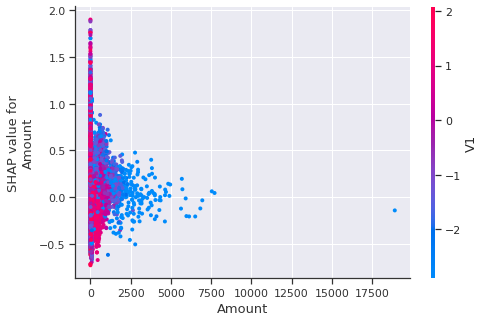

In [53]:
shap.dependence_plot("Amount", shap_values, df_Xtest)

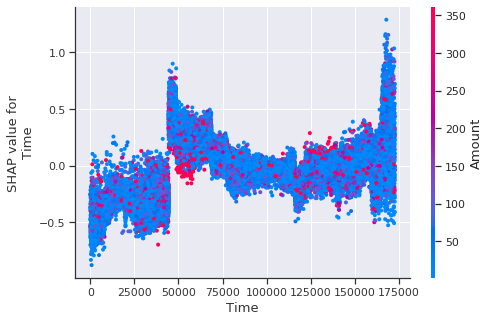

In [54]:
shap.dependence_plot(ind='Time', interaction_index='Amount',
                     shap_values=shap_values, 
                     features=df_Xtest,  
                     display_features=df_Xtest)

# HPO (Hyper Parameter Optimization)
We generally should optimize model complexity and then tune the convergence.

model complexity: max_depth etc
convergence: learning rate

Parameters:

- learning_rate: step size shrinkage used to prevent overfitting. Range is [0,1]
- depth: determines how deeply each tree is allowed to grow during any boosting round.
- subsample: percentage of samples used per tree. Low value can lead to underfitting.
- colsample_bytree: percentage of features used per tree. High value can lead to overfitting.

## Baseline model

In [56]:
model = CatBoostClassifier(verbose=100,random_state=100)

model.fit(df_Xtrain, ytr)

ypreds = model.predict(df_Xtest)

cm = confusion_matrix(ytest, ypreds)
print(cm)

Learning rate set to 0.073099
0:	learn: 0.4520944	total: 90ms	remaining: 1m 29s
100:	learn: 0.0016060	total: 8.23s	remaining: 1m 13s
200:	learn: 0.0011228	total: 16.4s	remaining: 1m 5s
300:	learn: 0.0008612	total: 24.5s	remaining: 57s
400:	learn: 0.0006628	total: 32.6s	remaining: 48.7s
500:	learn: 0.0005038	total: 40.8s	remaining: 40.6s
600:	learn: 0.0003722	total: 48.9s	remaining: 32.5s
700:	learn: 0.0002731	total: 57.1s	remaining: 24.4s
800:	learn: 0.0001932	total: 1m 5s	remaining: 16.2s
900:	learn: 0.0001492	total: 1m 13s	remaining: 8.08s
999:	learn: 0.0001250	total: 1m 21s	remaining: 0us
[[56863     1]
 [   22    76]]


## Using Early Stopping from Validation Set

In [59]:
params = dict(verbose=500,
              random_state=0,
              iterations=3_000,
              eval_metric='AUC',
              cat_features = [],
              early_stopping_rounds=200,
            )


model = catboost.CatBoostClassifier(**params)

model.fit(df_Xtrain, ytrain, 
          eval_set=(df_Xvalid, yvalid), 
          use_best_model=True, 
          plot=False
         );

Learning rate set to 0.084221
0:	test: 0.9164238	best: 0.9164238 (0)	total: 90.6ms	remaining: 4m 31s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9809169354
bestIteration = 43

Shrink model to first 44 iterations.


In [60]:
time_start = time.time()


model = CatBoostClassifier(verbose=False,random_state=0,iterations=50)
model.fit(Xtrain, ytrain)

ypreds = model.predict(Xtest)

cm = confusion_matrix(ytest, ypreds)
error = cm[0,1] + cm[1,0]

time_taken = time.time() - time_start
print('Time taken: {:.0f} min {:.0f} secs'.format(*divmod(time_taken,60)))

print('Errro confusion matrix', error)

# using 50 iterations is worse, use previous 1000.

Time taken: 0 min 5 secs
Errro confusion matrix 29


In [62]:
for n in [2,3,4,5,6,7,8,9,10]: # default detpth = 6

    model = CatBoostClassifier(verbose=False,random_state=0,
                              iterations=1_000,
                              depth=n,
                              )
    model.fit(Xtr, ytr)
    ypreds = model.predict(Xtx)
    cm = confusion_matrix(ytest, ypreds)
    error = cm[0,1] + cm[1,0]
    print(f'Confusion matrix error count = {error} for n = {n}')

Confusion matrix error count = 27 for n = 2
Confusion matrix error count = 25 for n = 3
Confusion matrix error count = 27 for n = 4
Confusion matrix error count = 25 for n = 5
Confusion matrix error count = 24 for n = 6
Confusion matrix error count = 24 for n = 7
Confusion matrix error count = 26 for n = 8
Confusion matrix error count = 26 for n = 9
Confusion matrix error count = 26 for n = 10


## Try Your luck with different random states

In [63]:
for n in [0,1,314,100,111,123,1234,12345]: 

    model = CatBoostClassifier(verbose=False,random_state=n,
                               depth=6,
                              iterations=1_000,
                              )
    model.fit(Xtr, ytr)
    ypreds = model.predict(Xtx)
    cm = confusion_matrix(ytest, ypreds)
    error = cm[0,1] + cm[1,0]
    print(f'Confusion matrix error count = {error} for n = {n}')

Confusion matrix error count = 24 for n = 0
Confusion matrix error count = 24 for n = 1
Confusion matrix error count = 25 for n = 314
Confusion matrix error count = 23 for n = 100
Confusion matrix error count = 23 for n = 111
Confusion matrix error count = 25 for n = 123
Confusion matrix error count = 25 for n = 1234
Confusion matrix error count = 25 for n = 12345


# Best Model

In [64]:
model = CatBoostClassifier(verbose=False,random_state=100,
                            depth=6,
                            iterations=1_000,
                            )
model.fit(Xtr, ytr)
ypreds = model.predict(Xtx)
cm = confusion_matrix(ytest, ypreds)
error = cm[0,1] + cm[1,0]
print(f'Confusion matrix error count = {error} for n = {n}')

Confusion matrix error count = 23 for n = 12345


In [65]:
print(cm)

[[56863     1]
 [   22    76]]
